<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours PCD - Labo 1

# Extraction d'attributs pour la détection du spam

## Résumé

Le but de ce travail est de réaliser des expériences de classification d'emails en *spam* ou *ham* (c'est-à-dire non-spam) grâce aux données et au code fourni intégralement dans ce notebook Jupyter.

Votre objectif sera de chercher les meilleurs attributs (*features*) qu'on puisse extraire des emails, ainsi que les classifieurs, afin de maximiser le score F1 de la classification spam/non-spam.  Les classifieurs utilisés seront de la famille Naive Bayes de Scikit-learn.

Veuillez rendre un notebook avec votre meilleure stratégie.  Présentez clairement les options et leurs résultats, et commentez-les brièvement.

*Source* : l'idée du labo vient du [premier notebook de Gan Sie Huai](https://github.com/huai99/Email-Spam-Detection-Python) avec plusieurs changements et mises à jour.

## 1. Obtention des données

Veuillez télécharger l'archive d'emails depuis Cyberlearn.  Ou téléchargez les cinq archives commençant par `20030228_` depuis https://spamassassin.apache.org/old/publiccorpus/.  Décompressez-les dans un dossier de votre choix dont vous indiquerez le chemin relatif dans `path`.

In [3]:
import os
import glob
import numpy as np
import email

In [4]:
path = 'data/spam_data/'

In [5]:
easy_ham_paths = glob.glob(path+'easy_ham/*')
easy_ham_2_paths = glob.glob(path+'easy_ham_2/*')
hard_ham_paths = glob.glob(path+'hard_ham/*')
spam_paths = glob.glob(path+'spam/*')
spam_2_paths = glob.glob(path+'spam_2/*')

In [6]:
def get_email_content(email_path):
    file = open(email_path,encoding='latin1')
    try:
        msg = email.message_from_file(file)
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                return part.get_payload() # prints the raw text
    except Exception as e:
        print(e)
        
        
def get_email_content_bulk(email_paths):
    email_contents = [get_email_content(o) for o in email_paths]
    return email_contents

## 2. Division en *train* et *test*
Le code suivant vous permet de diviser les données en *train* et *test* (sous-ensembles d'entraînement et de test).  Veuillez l'exécuter pour créer ces deux ensembles.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
ham_path = [easy_ham_paths, easy_ham_2_paths, hard_ham_paths]
spam_path = [spam_paths, spam_2_paths]

In [9]:
ham_sample = np.array([train_test_split(o) for o in ham_path], dtype=object)

In [10]:
for o in [train_test_split(o) for o in ham_path]:
    print(len(o[0]), len(o[1]))

1875 626
1050 351
188 63


In [11]:
ham_train = np.array([])
ham_test = np.array([])
for o in ham_sample:
    ham_train = np.concatenate((ham_train, o[0]), axis=0)
    ham_test  = np.concatenate((ham_test,  o[1]), axis=0)

In [12]:
ham_train.shape, ham_test.shape

((3113,), (1040,))

In [13]:
spam_sample = np.array([train_test_split(o) for o in spam_path], dtype=object)

In [14]:
for o in [train_test_split(o) for o in spam_path]:
    print(len(o[0]), len(o[1]))

375 126
1047 350


In [15]:
spam_train = np.array([])
spam_test = np.array([])
for o in spam_sample:
    spam_train = np.concatenate((spam_train,o[0]),axis=0)
    spam_test = np.concatenate((spam_test,o[1]),axis=0)

In [16]:
spam_train.shape, spam_test.shape

((1422,), (476,))

In [17]:
ham_train_label = [0]*ham_train.shape[0]
spam_train_label = [1]*spam_train.shape[0]
x_train = np.concatenate((ham_train,spam_train))
y_train = np.concatenate((ham_train_label,spam_train_label))

In [18]:
ham_test_label = [0]*ham_test.shape[0]
spam_test_label = [1]*spam_test.shape[0]
x_test = np.concatenate((ham_test,spam_test))
y_test = np.concatenate((ham_test_label,spam_test_label))

In [19]:
train_shuffle_index = np.random.permutation(np.arange(0,x_train.shape[0]))
test_shuffle_index = np.random.permutation(np.arange(0,x_test.shape[0]))

In [20]:
x_train = x_train[train_shuffle_index]
y_train = y_train[train_shuffle_index]

In [21]:
x_test = x_test[test_shuffle_index]
y_test = y_test[test_shuffle_index]

In [22]:
x_train = get_email_content_bulk(x_train)
x_test = get_email_content_bulk(x_test)

In [23]:
def remove_null(datas,labels):
    not_null_idx = [i for i,o in enumerate(datas) if o is not None]
    return np.array(datas)[not_null_idx],np.array(labels)[not_null_idx]

In [24]:
x_train,y_train = remove_null(x_train,y_train)
x_test,y_test = remove_null(x_test,y_test)

**Question :** combien d'emails y a-t-il dans le jeu d'entraînement et dans le jeu de test ?  Combien de spam et de ham, respectivement ?  Veuillez écrire le code qui fournit les réponses ci-dessous.

In [25]:
print(f"Taille du jeu d'entraînement: {len(x_train)}")
print(f"Taille du jeu de test: {len(x_test)}\n")

print(f"Spam dans le jeu d'entraînement: {np.sum(y_train)}")
print(f"Ham  dans le jeu d'entraînement: {len(y_train) - np.sum(y_train)}\n")

print(f"Spam dans le jeu de test: {np.sum(y_test)}")
print(f"Ham  dans le jeu de test: {len(y_test) - np.sum(y_test)}")

Taille du jeu d'entraînement: 3774
Taille du jeu de test: 1302

Spam dans le jeu d'entraînement: 755
Ham  dans le jeu d'entraînement: 3019

Spam dans le jeu de test: 290
Ham  dans le jeu de test: 1012


## 3. Pré-traitement et nettoyage des données

### 3.1 Traitements de bas niveau

In [26]:
import re
import string
from nltk.tokenize import word_tokenize

In [27]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

In [28]:
def to_lower(word):
    result = word.lower()
    return result

In [29]:
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

In [30]:
def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

In [31]:
def remove_whitespace(word):
    result = word.strip()
    return result

In [32]:
def replace_newline(word):
    return word.replace('\n',' ')

**Votre mission :** dans la fonction suivante, insérer dans le tableau `cleaning_utils` les noms des fonctions de pré-traitement que vous souhaitez utiliser afin d'obtenir le meilleur filtre anti-spam.   Veuillez commenter brièvement les raisons de votre choix.

In [33]:
def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink, remove_number, to_lower, remove_punctuation, remove_whitespace, replace_newline]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [34]:
x_train = [clean_up_pipeline(o) for o in x_train]
x_test = [clean_up_pipeline(o) for o in x_test]

### 3.2. Traitements linguistiques avec NLTK

Veuillez installer la librairie NLTK avec Conda ou `pip`, voir instructions à https://www.nltk.org.

In [35]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [36]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [37]:
def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return result

In [38]:
def word_stemmer(words):
    return [stemmer.stem(o) for o in words]

In [39]:
def word_lemmatizer(words):
    return [lemmatizer.lemmatize(o) for o in words]

**Votre mission :** dans la fonction suivante, insérer dans le tableau `cleaning_utils` les noms des fonctions de traitement linguistique que vous souhaitez utiliser afin d'obtenir le meilleur filtre anti-spam.  Veuillez commenter brièvement les raisons de votre choix.

In [40]:
def clean_token_pipeline(words):
    cleaning_utils = [word_stemmer, word_lemmatizer]
    for o in cleaning_utils:
        words = o(words)
    return words

**Remarque:** la tokenization peut prendre plusieurs minutes, vu la quantité de données.

In [41]:
x_train = [word_tokenize(o) for o in x_train]
x_test = [word_tokenize(o) for o in x_test]

In [42]:
x_train = [clean_token_pipeline(o) for o in x_train]
x_test = [clean_token_pipeline(o) for o in x_test]

In [43]:
x_train = [" ".join(o) for o in x_train]
x_test = [" ".join(o) for o in x_test]

# 4. Extraction des attributs (*feature extraction*)

À cette étape, on transforme les textes des emails en une série d'attributs.  Les méthodes proposées par Scikit-learn permettent de décider quels mots on garde comme attributs, puis les valeurs de chaque attribut pour chaque email.  Résultat : au lieu d'une chaîne de caractères, chaque email est représenté par une suite de nombres (de la même taille pour tous).

**Votre mission** : faire des expériences pour choisir entre les deux méthodes suivantes celle qui aboutira aux meilleurs résultats.

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
vectorizer = CountVectorizer()

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
vectorizer = TfidfVectorizer()

Transformation des textes des emails en vecteurs d'attributs.

In [48]:
def convert_to_feature(vectorizer, raw_tokenize_data):
    return vectorizer.transform(raw_tokenize_data)

In [49]:
vectorizer.fit(x_train)

TfidfVectorizer()

In [50]:
x_train_features = convert_to_feature(vectorizer, x_train)
x_test_features  = convert_to_feature(vectorizer, x_test)

## 5. Choix de la méthode de classification et entraînement

Dans cette section, vous allez pouvoir choisir le classifieur.  On vous propose de travailler avec un modèle de type *Naïve Bayes*, à choisir parmi plusieurs variantes disponibles dans Scikit-learn, et qui sont décrites à https://scikit-learn.org/stable/modules/naive_bayes.html.

Voici à titre d'exemple l'utilisation du classifieur *Naïve Bayes Multinomial*.

In [51]:
import sklearn.naive_bayes as nb

In [52]:
clf = nb.MultinomialNB()

In [53]:
clf.fit(x_train_features.toarray(), y_train) # entraînement du modèle

MultinomialNB()

In [54]:
clf.score(x_train_features.toarray(),y_train) # score F1 du modèle sur les données d'entraînement

0.8457869634340223

**Votre mission :** essayer plusieurs classifieurs basés sur l'approche *Naïve Bayes* et choisir celui qui aboutit au meilleur score *sur les données de test*, qui sera calculé dans la section suivante.

## 6. Évaluation du classifieur entraîné

Dans cette section, vous allez demander au classifieur de classer les données de test (non vues à l'entraînement), et calculer (grâce aux réponses correctes) plusieurs scores qui mesurent les performances de détection de spam.  Veuillez répondre aux questions posées en fin de section.

In [55]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [56]:
y_predict = clf.predict(x_test_features.toarray()) # réponses du système sur les données de test

In [57]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall:    {:.2f}%".format(100 * recall_score(y_test, y_predict)))
print("F1-score:  {:.2f}%".format(100 * f1_score(y_test, y_predict)))

Precision: 100.00%
Recall:    17.93%
F1-score:  30.41%


In [58]:
confusion_matrix(y_test, y_predict) # affichage élémentaire de la matrice de confusion

array([[1012,    0],
       [ 238,   52]])

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

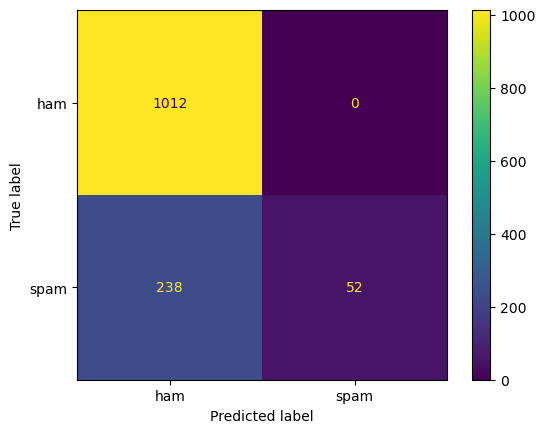

In [60]:
# affichage graphique de la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, display_labels = ['ham', 'spam']) 
plt.show()

**Veuillez répondre ici** aux questions suivantes :

1. Quel était votre premier score F1 obtenu ?  Quel est votre meilleur score ?  De combien avez-vous progressé grâce à vos choix judicieux ?

2. Quels choix de pré-traitement (section 3) vous ont conduit-e à la meilleure solution ?

3. Quelle représentation des emails vous a conduit-e à la meilleure solution ?

4. Quel classifieur vous a conduit-e à la meilleure solution ?

**Fin du Labo 1.**  Veuillez nettoyer ce notebook en gardant seulement les résultats désirés et vos réponses, l'enregistrer, et le soumettre comme devoir sur Cyberlearn.